In [5]:
import glob,os
import numpy as np
import pandas as pd
import MiStatHelpers as mi_helper
import simulation_helpers as sim_helper
import matplotlib.pyplot as plt
from scipy import stats

# Original Proposed Analysis

In the original proposed analysis we were interested in testing whether we saw some amount of coupling between oculo-motor movements, the cardiac cycle, the respiratory cycle, or there interaction (i.e. coupling with the cardiac cycle during certain parts of the respiratory cycle). Particularly we wanted to test this is relatively assumption from manner, where we did not assume all participants would have to show the same locations of coupling or that there was a single direction in which coupling should be observed at the individual participant level. This lead us to adopt a metric from the EEG literature the modulation index index. Which allowed us to ask whether we see any of these types of coupling with out making any of assumptions of uniformity, or unimodality mentioned above that we wanted to avoid. 

## Modulation Index

From our preregistration (https://osf.io/y58zs) we describe caclulation of the modulation index:

"To calculate the modulation index, we turn the angular location of all oculomotor events into a probability distribution for each cycle of interest and participant. We will make this distribution by creating 6 equally-sized bins of angular values across the cycle of interest, and then calculating the probability of the event of interest occurring in each of these bins. We then compare this calculated probability to a uniform distribution, which represents the null hypothesis of no coupling. The more two distributions differ the greater the evidence of coupling between the physiological cycle and the oculomotor event. For example, in our study, if there is no relationship between the cardiac or respiratory cycle and oculomotor events, then we expect each of the 6 bins will have roughly the same probability, i.e. a uniform distribution. The Modulation Index quantifies the difference between the calculated and uniform distributions with the Kullback-Liebler divergence, a measure of deviance between two distributions. If distributions are identical, the Kullback-Liebler divergence is 0, and the more different they are, the greater the Kullback-Liebler divergence."

In our pre-registration we also outlined that we planned to use the mean of boostrapped distribution as our estimate of the observed modulation index for each participant:

"Additionally to create a more reliable estimate of the observed modulation index, we will calculate the mean of a bootstrapped distribution of modulation indexes by resampling 80% of the data with replacement 1000 times. The mean of this bootstrapped distribution will then be used as a point estimate of the deviance from uniformity."

## Permutation Testing plan 

Then following others we plan to assess the significance of modulation index as a z-score of where our emperical modulation index fell in a perumuted null distribution of modulation indexes:

"Once we calculate the modulation index for an individual, we will assess its significance via permutation testing. To do this, we create a null distribution of modulation index values based on permuted data. We will calculate a single modulation index value from the null distribution by randomly permuting the timing of the oculomotor event of interest (saccade or fixation) in relation to the corresponding cardiac or respiratory cycle of interest, and then calculating the modulation index for this permuted data. This random permutation breaks any dependence between the ocular motor event and physiological cycle. We then repeat this procedure 1000 times creating a distribution of modulation indices under the null hypothesis of no coupling. We then take the mean and the standard deviation of the null distribution to calculate a z-score for the modulation index of the observed data (non-permuted). This z-score will serve as a comparison of the actual value of a participant’s modulation index to the null distribution of modulation indices. A positive z-score value would indicate there is more non-uniformity in a participant’s oculomotor events than one would expect under the null hypothesis.

To obtain a group level z-score and p-value across all participants’ modulation index z- values, we will use Stouffer's method (Stouffer et al., 1949) as described in Sherman et al. (2022)."


# Systematic Bias in Our proposed analysis

When completing our proposed analyses we found several systematic errors that biased our results and for which we are submitting an ammended pre-regristration plan. Below we outline each of the errors and show evidence of the ways in which it systematically biased our results.

The first two errors are a result of skew in our distributions causing the mean and statistics derived using the mean (i.e. Z-scores) to not be useful descriptions of the central tendencies of the underly distributions:

1. Calculating a z-value for the real modulation index  
2. Our use of the mean of the boostrapped modulation index distribution systematically over estimates distribution due to positive skew
3. Biological Implausibility of permutation tests


# Simulating random participants
First we simulate 600 participants where there is no effect of a simulated cyclical physiological signal (i.e. respiratory or cardiac cycle) on an behavioral event (i.e. saccades or fixations). We do this by first simulating 200 cycle lengths from a normal distribution. We chose the mean and standard deviation of the normal distribution to be 4 and .75 to mimic respiratory cycle. While we generated behavioral events at 3hz to mimic saccades. The "physiological" and "behavioral" time series are generated independently of each therefore have no stastical dependence (i.e. a modulation index of close to zero).

In [8]:
generate_new_data = False
# The folder names as seen in the uploaded picture
folder_names = [ "simulated_random_participants",
                "simulated_biologically_plausible_participants_shifted_stats",
                "simulated_biologically_plausible_participants_shifted",
                "simulated_biologically_plausible_participants_aligned_stats",
                "simulated_biologically_plausible_participants_aligned"
               ]
base_dir = ''
if generate_new_data:
    for folder_name in folder_names:
        folder_path = os.path.join(base_dir, folder_name)
        os.makedirs(folder_path, exist_ok=True)


In [11]:
# creating simulated participants 
n_bins = 6
perm_col ='Angle'
bins_col = 'Angle_bins'
event_col = 'Saccade_Indicator'
n_iterations_mi=500
boot_strap_frac = .8
n_boots = 1000
save_path ='simulated_random_participants/sim_par_{}_{}.txt'
if generate_new_data:
    for par in range(600):

        df = sim_helper.simulate_cycle_data()

        # create modulation index
        df[bins_col]=mi_helper.create_bins_for_col(df,'Angle',n_bins=n_bins)
        event_df = df[df[event_col]==1]
        prob_dist_real = (event_df[bins_col].value_counts())/len(event_df)
        par_mod_index = mi_helper.calc_modulation_index(prob_dist_real,n_bins)
        rand_mod_index_list = mi_helper.create_permute_null_distribution(
            df,
            perm_col,
            event_col,
            n_bins,
            n_iterations=n_iterations_mi,
            tqdm_disabled=True
        )
        boostrapped_dist = mi_helper.create_bootstrapped_test_stat(
            event_df,
            bins_col,
            boot_strap_frac = boot_strap_frac,
            n_boots = n_boots,
            n_bins=n_bins,
        )

        # save data
        np.savetxt(save_path.format(par,'boostrap'),boostrapped_dist)
        np.savetxt(save_path.format(par,'null'),rand_mod_index_list)
        np.savetxt(save_path.format(par,'realmod'),[par_mod_index])

        if par % 10 ==0:
            print(par)

# 1. Z values of real modulation index under estimate location in null distribution
Simulated data shows calculating z-score value for the modulation index based on the permuted null distribution introduces bias into the analysis. 

First to develop some inituition we show the histogram of the permuted null distribution for 3 simulated participants. we plot the histrogram of the null distribution, their actual modulation index, and the z value for that modulation index. In the first 6 histrograms below one can see how the skew in the null distribution causes the z-score not to be a good measure of where the modulation index falls in the null distribution. 

Next show the distribution of z-scores aggregated across the 600 simulated participants. The mean, median, and mode of the distribution of z-scores across participants below  zero. This results suggests some bias in our tests, as we know the saccades are generated randomly therefore we expect the mean,median, and mode of the z-score distribution to be ~0. 

Finally the last histogram shows that when using the percentile of the real modulation index in the null distribution rather then the z-score the bias disappears.  Note - we expect the histogram of percentiles to be a uniform distribution under the null hypothesis since no percentile should be more likely than any other when data is generated randomly.

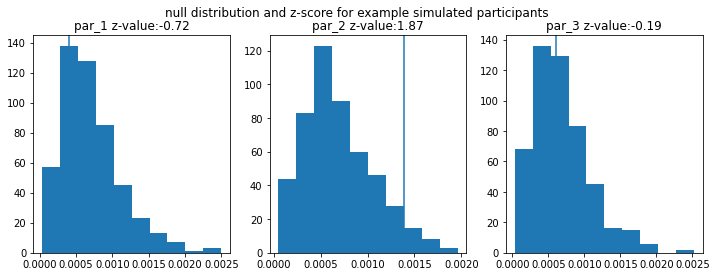

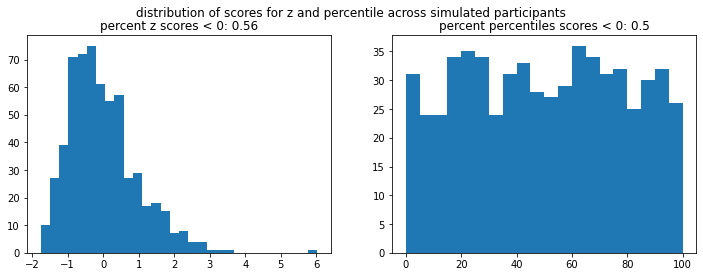

In [12]:
z_mods,percentiles = [],[]
fig,axes = plt.subplots(1,3,figsize=(12,4))
example_par = 0
for par in range(600):
    real_mod = np.loadtxt(save_path.format(par,'realmod'))
    null_dist = np.loadtxt(save_path.format(par,'null'))
    mean,std=np.mean(null_dist),np.std(null_dist)
    z_mod = (real_mod-mean)/std
    percentile = stats.percentileofscore(null_dist,real_mod)
    z_mods.append(z_mod),percentiles.append(percentile)
    
    if par % 200 ==0:
        axes[example_par].hist(null_dist)
        axes[example_par].axvline(real_mod)
        axes[example_par].set_title(f'par_{example_par+1} z-value:{round(z_mod,2)}')
        example_par+=1
fig.suptitle('null distribution and z-score for example simulated participants')
plt.show()

fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(z_mods,bins=30)
axes[0].set_title(f'percent z scores < 0: {round(sum(np.array(z_mods)<0)/len(z_mods),2)}')


axes[1].hist(percentiles,bins=20)
axes[1].set_title(f'percent percentiles scores < 0: {round(sum(np.array(percentiles)<50)/len(percentiles),2)}')
fig.suptitle('distribution of scores for z and percentile across simulated participants')
plt.show()


# 2. Using the mean of boostrapped MI distribution over estimates the Modulation Index

In our original analysis we proposed calculating the modulation index as the mean of boostrapped distribution of 500 modulation indices each calculated with 80% of the observed data. Below our simulations show that this introduces a positive bias in the test.

Again we first show the histograms of the permuted null distribution of modulation index for 4 individual particiapnts to build intuition. The bias can be seen in the plot below where the mean of the boostrap distribution (red line) is consistently larger then real modulation index (green line).

Next we show the histogram of the percentile scores of the of the modulation index calculated as the mean of the boostrapped distribution. This histogram shows significant left skew, with most of it's values well above 50%, whereas since we know there is no effect we expect an equal number of values in the histrogram to be above and below 50%.

Finally we show that when using the real modulation index (as opposed the mean of bootstrapped distribution of the modulation index) this bias disappears. The histogram of percentiles is roughly uniform, and has the same amount of values above and below the 50%.

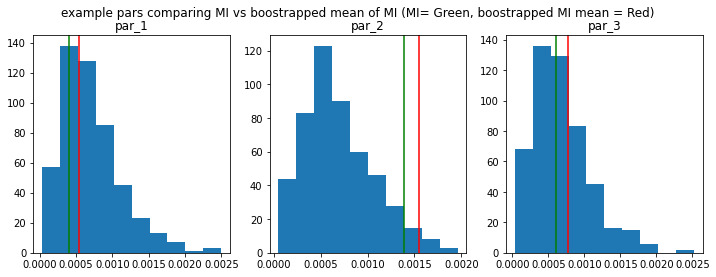

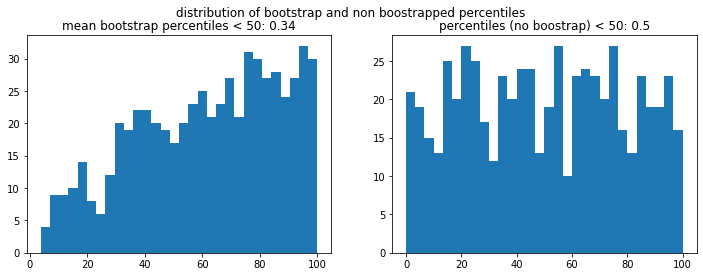

In [14]:
percentiles,percentiles_bootstrapmean = [],[]
fig,axes = plt.subplots(1,3,figsize=(12,4))
example_par = 0
for par in range(600):
    real_mod = np.loadtxt(save_path.format(par,'realmod'))
    null_dist = np.loadtxt(save_path.format(par,'null'))
    boostrap_dist = np.loadtxt(save_path.format(par,'boostrap'))
    mean_boostrap = np.mean(boostrap_dist)
    percentile = stats.percentileofscore(null_dist,real_mod)
    boostrap_percentile = stats.percentileofscore(null_dist,mean_boostrap)
    percentiles.append(percentile)
    percentiles_bootstrapmean.append(boostrap_percentile)
    if (par % 200) ==0:
        axes[example_par].hist(null_dist)
        axes[example_par].axvline(real_mod,color='green')
        axes[example_par].axvline(mean_boostrap,color='red')
        axes[example_par].set_title(f'par_{example_par+1}')
        example_par+=1
fig.suptitle('example pars comparing MI vs boostrapped mean of MI (MI= Green, boostrapped MI mean = Red)')       
shown = plt.show()

fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(percentiles_bootstrapmean,bins=30)
axes[0].set_title(f'mean bootstrap percentiles < 50: {round(sum(np.array(percentiles_bootstrapmean)<50)/len(percentiles_bootstrapmean),2)}')

axes[1].hist(percentiles,bins=30)
axes[1].set_title(f'percentiles (no boostrap) < 50: {round(sum(np.array(percentiles)<50)/len(percentiles),2)}')
title_out=fig.suptitle('distribution of bootstrap and non boostrapped percentiles')

# Continued Bias in our empirical results

Finally when we re-ran our basic sets of analyses we continued to observe that our emperical distributions were more uniform than chance. Based on Sherman et al. 2022 we believed this might be because parts of the cardiac or respiratory cycles that were relatively undersampled during the task, had relatively more oculo-motor movements in them which would cause a more uniform distribution of oculomotor events across the cycle of interest compared to chance. To investigate whether this would be the case we enforced a perfect uniform distribution of cardiac/respiratory cycle angles by taking the angular bin with smallest number of samples in it, N, then sampling with out replace N samples from each other bin so there was a perfectly equal number of samples in our trial data in each bin. This procedure created a perfectly uniform distribution. However even once we did this and ran our analyses we saw that there was still a heavy negative skew in our data. For each of the main effects of cycle we looked at the mean of the percentiles was well below zero, which if there were no effect of cycle on the data we would not expect.

<img src='empirical_figures/empirical_cardiac_mi_percentiles.png'> 

<img src='empirical_figures/empirical_resp_mi_percentiles.png'> 
Based on these results we believe the permutation testing doesn't provide a biologically appropriate baseline. This biological implausibility is clear from that in when the data is permuted 3 oculomotor events in a cycle are equally as likely to occur at angles 1, 2, 3, and 90, 180, 270. We know that the latter possibility is far more likely given that we know saccades do not occur instanteously as well as that there is an information gathering process (fixation) separating each saccade. 

In [8]:
empirical_data = False #emperical data will be released upon publication of first analysis
if empirical_data:
    # participants included
    par_list_file = '/work/abslab/Kieran/CardioRespiratory/Code/pars_for_analysis.csv'
    par_list_df = pd.read_csv(par_list_file)
    par_list_df['par']= par_list_df['par'].astype(int)
    # modality='cardiac'
    # eye_event = 'mean_fixation'
    for modality in ['cardiac','resp']:
        fig,axes = plt.subplots(1,2,figsize=(12,4))
        for evt_idx,eye_event in enumerate(['mean_fixation','saccade_start']):
            z_list = []
            percentile_list = []
            for par in par_list_df['par']:
                null_dist_path = f'/work/abslab/Kieran/CardioRespiratory/Results/modulation_index_calcs/{modality}/{modality}_{eye_event}_null_mi_dist_{par}_clipped_uniform-enforce.csv'
                real_dist_path = f'/work/abslab/Kieran/CardioRespiratory/Results/modulation_index_calcs/{modality}/{modality}_{eye_event}_real_mi_dist_{par}_clipped_uniform-enforce_percentiles_nobootstrap.csv'
                null_dist = np.loadtxt(null_dist_path)
                real_dist = np.loadtxt(real_dist_path)

                mean_null, std_null = np.mean(null_dist),np.std(null_dist)
                mean_real = np.mean(real_dist)
                z_score = (mean_real - mean_null)/std_null
                z_list.append(z_score)
                percentile = stats.percentileofscore(null_dist,mean_real)

                percentile_list.append(percentile)
            axes[evt_idx].hist(percentile_list)
            axes[evt_idx].set_title(f'{eye_event} mean percentile: {round(np.mean(percentile_list),2)}')
        fig.suptitle(f'distribution {modality} MI percentiles')
        plt.savefig(f'empirical_figures/empirical_{modality}_mi_percentiles.png')



## Simulated biologically plausible, but random (cycle independent) participants recapitulate bias in emperical results

Below we simulate data with events (in our running example saccades), with no relation to a biological rhythm generated simultaneosuly. The difference between this simulation and our previous simulations is that in this one we  simulate the events under a set of biologically plausible parameters, as opposed to purely randomly. Our biologically plausible simulations change the event generating process by assuming that for a short period following each generated event no other event will occur. This assumption consistent with most biological events requiring some refractory period, for instance in our example that saccades cannot occur in adjacent sample periods (measured in ms in our experiment) because each saccade takes longer than a 1 single ms.

As seen in the figure below once these assumptions are added to the data generating process the simulated data, where events continue to have no dependence on the angular values associated with the simulated cycle, show the exact same bias as our emperical results that a marked right skew of the distribution of percentile scores towards zero. This results gives us further evidence that our permutation method yields bias results and we need to look else where to establish a valid null distribution

Finally it's worth noting the values chosen for this simulation for the event frequency, minimum delays between events event are not meant to be exact but just to broadly show how introducing the structure inherent in biological data influences are results. 


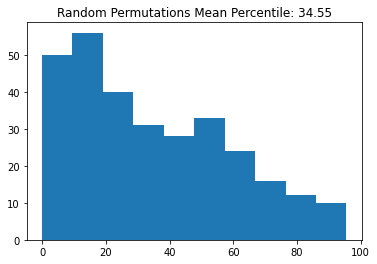

In [39]:
random_percentile_list, shifted_percentile_list = [], []
number_of_events_per_second=4
min_time_between=50
for par in range(300):
    par_str = f'par-{par}_trials-100_cycles-3_lencycle-4_stdcycle-(0.75,)_eps-{number_of_events_per_second}_mtb-{min_time_between}'
    out_str = f'simulated_biologically_plausible_participants_random_stats/shifted_{par_str}.npz'
    data = np.load(out_str)
    random_null_dist = data['random_null']
    shifted_null_dist = data['shifted_null']
    real = data['real_mi']
    random_percentile = stats.percentileofscore(random_null_dist, real)
    random_percentile_list.append(random_percentile)
    shifted_percentile = stats.percentileofscore(shifted_null_dist, real)
    shifted_percentile_list.append(shifted_percentile)

# Plot histograms in the respective rows
plt.hist(random_percentile_list)
title_txt = plt.title(
    f'Random Permutations Mean Percentile: {round(np.mean(random_percentile_list), 2)}')


# Circular Shift Permutations

### Glossary of terms for next section

random permutation: permutations generated via randomly reassigning angular values to events

shifted permutation: permutations generated via a random shift applied to all angular values at the trial, run, or experiment level

fixed angle start: Data is generated such that each trial begins at the same angle.

random angle start: Data is generated such that each trial begins at a random angle.


## Circular shift
As an alternative to pure random permutations used above is to generate our null distribution via adding random shifts to the angular data. Adding a random shift to the angular data breaks any association between parts of the cycle and biological events but maintains the overall structure of the biological events. Maintaing this structure ensures that biologically implausible patterns of events (i.e. events in adjacent angles) are not included in null distribution.

When adding a circular shift one needs to decide which portion of data to shift. For example if one were to add a circular shift to the entire time series this would not test if there is some coupling effect of the physiological cycle and events, as the mutual information would be the same for each permutation, the bins which were had or more less events would just vary based on the shift. Given that in our experiment the eyetracking data is organized into discrete trials with small periods with no tracked data in between each trial for our shifted permutted distribution for each permutation we added a different random angular shift for each trial.

## simulated participants
To test the validity of this method we generated a new set of simulated participants. To look at the levels of bias across different sets of parameters for the simulated participants we varied both the number of behavioral events per dd (events per second options ({1,2,4,8,16}), as well as the minimum time between these events ({0,25,50,100}). For each combination of these parameters we generated 300 participants for which at least half of the time was not taken up by the refractory period. For example in if there were 2 events per second and a refractory period of 100ms we would expect 200ms per second to be a refractory period, thus we would participant for this combination, in contrast for the 8 events per second and 100ms refractory period we would expect 800ms per second to be in a refractory period - thus we would not generate participant for this combination.  Each participant had 100 "trials", each trial consisted of 3 physiological cycles, with cycle lengths drawn from the same normal distribution (mean = 4, std=.75), the number of behaivoral events was stochastic and depended on number of events per second. The code to reproduce the generation of participants is in (generate_combos_biological_plausible.py). Generating participants with a range of biologically plausible parameters allowed us to assess how the circular shift method, and the random permuation methods fared. This allows us to generalize our findings more broadly, for instance since time is relative (based on the sampling) in these analyses, an analysis of 1 event per second, with a minimum time between events of 100ms is approximately equal to simulating a biological signal with a mean duration of 1 second (i.e. the cardiac cycle), with 4 events per second, and 25ms between each event. 

## Comparing shifted and random permutations
    
   After generating the biologically plausible participants with a range of events per second and minimum time between events we under took several tests of the permutation methods for calculating a modulation index. At the most basic level for each combination of events per second and minimum time between events we calculated the percentile of the modulation index of the observed data with that of random and shift null distributions. We found that when events occur more frequently, and have a longer minimum time between them the random permutation method becomes more and more bias while the circular shift method remains un-biased across a wide range of biologically plausible parameters. 
   
Below we show an example set of histograms demonstrating the unbiased nature of shifted permutation method compared to the random permutations. This plot shows when events are generated with a refractory period of 25ms that the random permutation shows bias when the events per second becomes more and more biased as the number of events per second increases. Each column in a set of plots is random vs shifted method of calculating the permuted null distribution, and each row is the number of events per second parameter.

<img src='figures_for_shift_vs_random/start-random_min_time-25.png'>

Note how the random permutation method shows biased across most sets of biologically plausible paramters, while the shifted permutation method does not (mean percentiles ~50). The same trend can be seen in participants simulated with other sets of biologically plausbile parameters. Overall as more structure that is introduced (by either a greater refractory period or more events per second combined with a non-zero refractory period) the greater the bias in random permutation method. Histograms for all generated participants can be seen in the figures_for_shift_vs_random folder all files starting with "start-random".

Overall our results show a shifted permutation method of estimating the percentile location of the modulation index is unbiased across a range of biologically plausble parameters for simulated participants and is preferable over a purely random simulation.

Interestingly we also showed that when all trials are generated with the same start angle for each "trial", this also introduced bias (see figures_for_shift_vs_random folder all files starting with "start-aligned"). We interpret this to suggest that in our set of the randomness is not so great that even if behavioral events are generated separately from the biological signal, if the beginning of the event generation process are aligned in with the same starting angle of the data generating process the semi-structured nature of event generation causes events to show some modulation in line with the time periodicitiy of the physiological cycle. We do not believe this impacts the main take away of our simulations, but suggests the ways in which the modulation index is quite sensitive to factors that may introduce some dependency between the behavioral events and physioloigcal cycles.
   
Code for generating the modulation index and the random and shift permuted null distributions is in run_permutation_tests_parallel.py and run a HPC with wrapper_run_permutation_test.sh. Figures in this section were generated with create_shifted_vs_random_figs.py.



In [6]:
import os, glob
import numpy as np
globbed = glob.glob('simulated_biologically_plausible_participants_random_stats/*')

In [7]:
end_names = [glob_path.split('.')[-1] for glob_path in globbed]
np.unique(end_names)

array(['npz'], dtype='<U3')